# Rejection Approximate Bayesian Computation (REJ-ABC) for parameter inference of a repressilator

First we define the distance function, in this case Euclidean distance

In [1]:
import numpy as np
#Distance function
def euclidean_distance_multiple_trajectories(observed_trajectories, simulated_trajectories):
    num_trajectories = len(observed_trajectories)
    total_distance = 0.0

    for i in range(num_trajectories):
        observed_data = observed_trajectories[i]
        simulated_data = simulated_trajectories[i]

        # Calculate the Euclidean distance between observed and simulated data
        euclidean_distance = np.linalg.norm(observed_data - simulated_data)

        # Accumulate the distances
        total_distance += euclidean_distance

    # Average the distances over all trajectories
    average_distance = total_distance / num_trajectories

    return average_distance

Secondly we specify a smoothing kernel as a function of $\epsilon$ as an alternative to a regular distance threshold cutoff

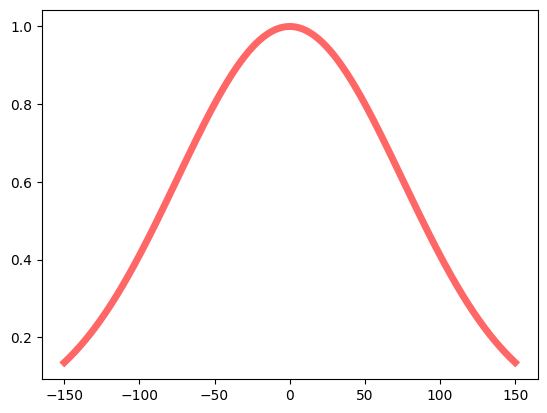

In [3]:
#Visualise the smoothing kernel wrt epsilon
       #We have a 0.135 chance of accepting above the threshold!
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
epsilon = 150
x = np.linspace(-epsilon, epsilon, 1000)
normalising_factor = 1/norm.pdf(0, loc=0, scale = epsilon)
ax.plot(x, norm.pdf(x, loc=0, scale=epsilon/2)*normalising_factor/2,

       'r-', lw=5, alpha=0.6, label='norm pdf')

In [4]:
epsilon = 150 #Results independent of epsilon
norm.pdf(-epsilon, loc=0, scale=epsilon/2)*normalising_factor/2

0.1353352832366127

## We now specify the model, the ode solver, the true parameters and the true data

In [ ]:
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Define the model
def model(variables, t, params):
    m1, p1, m2, p2, m3, p3 = variables
    k1, k2 = params

    dm1dt = -m1 + (10 ** 3 / (1 + (10 ** k1 * p2) ** 2)) + 1
    dp1dt = -10 ** 0 * (p1 - m1)

    dm2dt = -m2 + (10 ** 3 / (1 + (10 ** k2 * p3) ** 2)) + 1
    dp2dt = -10 ** 0 * (p2 - m2)

    dm3dt = -m3 + (10 ** 3 / (1 + (10 ** 0 * p1) ** 2)) + 1
    dp3dt = -10 ** 0 * (p3 - m3)

    return [dm1dt, dp1dt, dm2dt, dp2dt, dm3dt, dp3dt]

#Define true parameters
true_params = np.array([
    0, 0  # first set of odes
])

#Define the solver using odeint
def solve_ode(params, t):
    initial_conditions = np.array([0, 1, 0, 3, 0, 2])
    solution = odeint(model, initial_conditions, t, args=(params,))
    return solution

num_timesteps = 1000  # Number of time steps for simulation
t = np.linspace(0, 100, num_timesteps) #Range of time of simulation
true_data = solve_ode(true_params, t) #True trajectories

epsilon = 100 # Error threshold used in kernel, restrictive
num_samples = 10000  # Number of samples to draw

# Try to infer $k_{1}$ and $k_{2}$ with a tight threshold of $\epsilon = 100$

Define REJ-ABC algorithm

In [7]:
# ABC rejection
from scipy.stats import norm
def abc_rejection(true_params, epsilon, num_samples):
    accepted_params = []
    accepted_data = []  # Added to store simulated data for accepted parameters
   
    for _ in range(num_samples):
        # Define prior and sample
        sampled_params = np.random.uniform(low=-3, high=3, size=len(true_params)) #Wide priors
       
        # Generate synthetic data using samples
        sampled_data = solve_ode(sampled_params, t)

        distance = euclidean_distance_multiple_trajectories(true_data, sampled_data)
        normalising_factor = 1/norm.pdf(0, loc=0, scale = epsilon)
        smooth_threshold = norm.pdf(distance, loc=0, scale=epsilon/2)*normalising_factor/2
        rdm_tmp = np.random.uniform(low=0, high=1, size=1)
        if rdm_tmp < smooth_threshold: #If the random number is below the threshold, we accept it
            accepted_params.append(sampled_params)
            accepted_data.append(sampled_data)
   
    return np.array(accepted_params), np.array(accepted_data)



In [ ]:
accepted_parameters, accepted_data = abc_rejection(true_params, epsilon, num_samples)

Plot posteriors and inferred parameters

In [ ]:
k1_accept = []
k2_accept = []
for i in range(len(accepted_parameters)):
    k1_accept.append(accepted_parameters[i][0])
    k2_accept.append(accepted_parameters[i][1])
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(k1_accept, k2_accept, color = "green") 
ax.set_xlabel(r"$k_{1}$", fontsize = 20) 
ax.set_ylabel(r"$k_{2}$", fontsize = 20) 
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])
plt.show()

In [ ]:
import seaborn as sns
import pandas as pd
plot_k = pd.DataFrame(data=np.array([k1_accept, k2_accept]), index=(r"$k_{1}$", r"$k_{2}$"))
plot_k_t = pd.DataFrame.transpose(plot_k)
sns.pairplot(plot_k_t, kind="kde")

In [ ]:
# Plot histograms
fig, axs = plt.subplots(1, len(true_params), figsize=(15, 5), sharey=True)
all_accepted_parameters_array = np.array(accepted_parameters)
for i, param_name in enumerate(headers):
    axs[i].hist(all_accepted_parameters_array[:, i], range=[-3, 3], bins=30,alpha=0.7, color='orange')
    axs[i].set_xlabel(param_name)
    axs[i].set_ylabel('Frequency')